In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import numpy as np

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
0,pretrained_complete,linear_regression,Transformer,,-1,-1,20,12,8,fix_linear_regression_standard


In [4]:
task = "linear_regression"
#task = "sparse_linear_regression"
# task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "pretrained_complete"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

run_name: fix_linear_regression_standard, id: pretrained_complete


100%|██████████| 15/15 [00:00<00:00, 165130.08it/s]


------------------------
basic_plot: ['Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging']


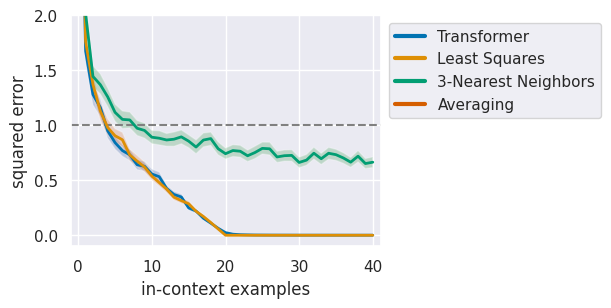

In [5]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [6]:
from samplers import get_data_sampler
from tasks import get_task_sampler
print(conf.training.curriculum.points.end)

51


In [7]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size
data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)
with torch.no_grad():
    pred = model(xs, ys)
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]



### 4.1 Sample Selection / Covariate Shifts

In [8]:
def R_Square_Error(ys, pred):
    # Step 2: Calculate the mean of the actual outcomes
    y_mean = torch.mean(ys)

    # Step 3: Compute SS_tot and SS_res
    SS_tot = torch.sum((ys - y_mean) ** 2)
    SS_res = torch.sum((ys - pred) ** 2)

    # Step 4: Calculate R^2
    R_square = 1 - SS_res / SS_tot
    return R_square

####  Expriment 1

In [13]:
import torch.optim as optim

In [22]:
# ####  Part 1 - Sample Selection: W1 = 1, w2 = 0
'''
The following is a framwork for prompt tuning with one batch for t=10
'''
batch_size = 64
prompt_length = 78
xs = data_sampler.sample_xs(b_size=batch_size, n_points=prompt_length) # shape: 64 x 78 x 20
ys = task.evaluate(xs) # shape: 64 x 11
# Note: the above act as an initialization for the prompts: x_1 ~ x_10, y_1 ~ y_10

# Freeze all the model parameters
for param in model.parameters():
    param.requires_grad = False
    
# Set the x and y except the test example (i.e., y_11) as trainable parameters
xs = nn.Parameter(xs)
ys = nn.Parameter(ys)
# xs_trainable = nn.Parameter(xs[:, :-1, :].requires_grad_(True))
# ys_trainable = nn.Parameter(ys[:, :-1].requires_grad_(True))

xs.requires_grad_(True)
ys.requires_grad_(True)

def backward_hook_xs(grad):
    grad[:, -1, :] = 0  # Set gradient for the last item to 0
    return grad

def backward_hook_ys(grad):
    grad[:, -1] = 0  # Set gradient for the last item to 0
    return grad

xs.register_hook(backward_hook_xs)
ys.register_hook(backward_hook_ys)


In [23]:
# Define epochs where the learning rate will change and the corresponding learning rates
lr_schedule = {
    2000: 0.001,  
    5000: 0.0001  }

# Create a lambda function that returns the multiplier for the learning rate based on the current epoch
def lr_lambda(epoch):
    for milestone in sorted(lr_schedule, reverse=True):
        if epoch >= milestone:
            return lr_schedule[milestone] / 0.1  # Divide by initial lr to get the factor
    return 1.0  # Before any changes occur, use the initial lr



In [25]:


optimizer = torch.optim.SGD([xs, ys], lr=0.01)
# Create the scheduler
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
loss_fn = nn.MSELoss()

# Train xs and ys for N steps, here use N=10
N = 10000
for step in range(N):
    optimizer.zero_grad() 
    # output with prompts xs and ys

    output = model(xs, ys) 
    xs_test = xs[:,-1,:].detach().unsqueeze(1)
    ys_test = ys[:, -1].detach().unsqueeze(1)
    # output only with xs[:,-1,:], this output acts as the labels to calculate loss
    test_target = model(xs_test, ys_test)
    output_target = output[:,-1].unsqueeze(1)
    loss = loss_fn(output_target, test_target)

    if step % 2 == 0:
        current_lr = scheduler.get_last_lr()[0]  # Get the current learning rate
        print(f'Step {step}: Loss = {loss.item()}, LR = {current_lr}')
    loss.backward()               
    optimizer.step()
    scheduler.step()
    
#return the loss in last iteration as the value to plot figure 

# The above is the loss for one batch, (in the last iteration)
# Loop for 100 batch, you get 100 loss value, average them to get the loss value for t=10
# Loop for t = 1:75

Step 0: Loss = 77.64359283447266, LR = 0.01
Step 2: Loss = 75.19257354736328, LR = 0.01
Step 4: Loss = 72.82064056396484, LR = 0.01
Step 6: Loss = 70.50799560546875, LR = 0.01
Step 8: Loss = 68.23860931396484, LR = 0.01
Step 10: Loss = 65.99942779541016, LR = 0.01
Step 12: Loss = 63.78005599975586, LR = 0.01
Step 14: Loss = 61.572784423828125, LR = 0.01
Step 16: Loss = 59.37290954589844, LR = 0.01


KeyboardInterrupt: 